In [32]:
import os
import pickle
import sys
from datetime import datetime as dt

import hydra
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
import torchmetrics
from tqdm.auto import tqdm

sys.path.append("..")

from src.lib.config import register_configs  # noqa
from src.utils.EvalWrapper import EvalWrapper  # noqa
from src.utils import utils  # noqa
from src.utils.eval_single_helper_funcs import get_confidence_and_acc_single, get_distribution_file  # noqa
from src.models.LightningBaseModel import LightningModel  # noqa
from src.utils.eval_single_helper_funcs import get_best_checkpoints  # noqa

register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)

sns.set()

<class 'ValueError'>


In [2]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/publication/supervised_singlelabel",
                                                     "random_seed=7",
                                                     "strategy=SingleDevice",
                                                     'strategy.device="cuda:0"',
                                                     "trainer.enable_progress_bar=false",
                                                     "datamodule.batch_size=64"])

train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup(stage="fit")

Global seed set to 7
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:95: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
77it [00:00, 4833.02it/s]                                                                                                   | 0/19 [00:00<?, ?it/s]
4536it [00:00, 8410.93it/s]
88it [00:00, 8540.20it/s]██████                                                                                     | 2/19 [00:00<00:04,  3.56it/s]
100it [00:00, 6791.41it/s]
95it [00:00, 8617.56it/s]
288it [00:00, 8935.14it/s]
12it [00:00, 4176.21it/s]
158it [00:00, 7514.97it/s]
59it [00:00, 6257.94it/s]████████████████████████████████████                                                       | 8/19 [00:00<00:00, 14.61it/s]
1215it [00:00, 12714.58it/s]
386it [00:00, 16044.01it/s]
56it [00:00, 8671.04it/s]
1290it [00:00, 14820.66it/s]████

In [3]:
class_names = dict()
for key, value in datamodule.integer_class_label_dict.items():
    class_names[value] = key

In [4]:
# set global values:


experiments_paths = {
        "supervised_singlelabel_vanilla": [
            "/gpfs/work/machnitz/plankton_logs/supervised_vanilla/singlelabel/multirun/2022-07-12/09-20-42"],
        "supervised_singlelabel": [
            "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24",
            "/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-18/12-00-06"
    ],
    }


base_paths = ["/gpfs/work/machnitz/plankton_logs/eval/singlelabel/multirun/2022-07-12/12-49-00/0/logs/checkpoints/test_results",
              "/gpfs/work/machnitz/plankton_logs/eval/singlelabel/multirun/2022-05-19/08-24-05/0/logs/checkpoints/test_results",
             ]

experiments = []
for key, paths in experiments_paths.items():
    for path in paths:
        experiments += get_best_checkpoints(path)
        
# experiments = [os.path.join(os.path.split(exp)[0], "last.ckpt") for exp in experiments]
num_total_train_images = 143343

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Did not find checkpoint for /gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/12


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
experiments

['/gpfs/work/machnitz/plankton_logs/supervised_vanilla/singlelabel/multirun/2022-07-12/09-20-42/0/logs/checkpoints/epoch=05-v1.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/7/logs/checkpoints/epoch=12.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/6/logs/checkpoints/epoch=09.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/3/logs/checkpoints/epoch=22.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/11/logs/checkpoints/epoch=01-v5.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/5/logs/checkpoints/epoch=11.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/2/logs/checkpoints/epoch=41.ckpt',
 '/gpfs/work/machnitz/plankton_logs/supervised/singlelabel/multirun/2022-05-16/09-45-24/4/logs/checkpoints/epoch=33.ckpt',
 

In [6]:
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()

hereon_color_array = np.array([
    [230, 0, 70],
    [0, 145, 160],
    [0, 170, 230],
    [250, 180, 35],
    [0, 70, 125],
    [175, 25, 60],
    [170, 200, 70],
    [250, 115, 80],
    [140, 90, 180],

])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

In [7]:
def custom_accuracy(y_pred, y_true):
    
    _, preds =  torch.max(y_pred, dim=1)
    
    score = y_true == preds
    return score.float().mean()

def instantiate_model(ckpt_path):
    model = LightningModel.load_from_checkpoint(checkpoint_path=ckpt_path)
    model.set_external_data(
        class_labels=[1],
        all_labels=None,
        example_input_array=None,
    )
    return model

# Single Label

In [8]:
def get_training_walltime(_file):
    _path = os.path.split(_file)[0] + "../../.."
    log_file = os.path.abspath(os.path.join(_path, "main.log"))
    with open(log_file, "r") as f:
        lines = f.readlines()
    
    start_str = lines[0].split(",")[0][1:].strip()
    start_time = dt.strptime(start_str, "%Y-%m-%d %H:%M:%S")
    
    end_str = lines[-1].split(",")[0][1:].strip()
    end_time = dt.strptime(end_str, "%Y-%m-%d %H:%M:%S")
    
    wall_time = float((end_time - start_time).total_seconds() / 60)
    
    return wall_time


In [34]:
def get_key_from_filename(_file):
    normed_file = os.path.normpath(_file)
    _key = normed_file.split("plankton_logs/")[-1].split("/singlelabel/")[0] + "_singlelabel"
    _experiment_number = int(normed_file.split("/logs/")[0].split("/")[-1])
    
    return _key, _experiment_number


best_checkpoints = []
return_metrics = dict()
acc_func_macro = torchmetrics.Accuracy(average="macro", num_classes=15)
acc_func_weighted = torchmetrics.Accuracy(average="weighted", num_classes=15)
acc_func_all = torchmetrics.Accuracy(average="none", num_classes=15)
acc_func_micro = torchmetrics.Accuracy(average="micro")
acc_func_custom = custom_accuracy
ConfusionMatrix = torchmetrics.ConfusionMatrix(num_classes=15)
ConfusionMatrixNorm = torchmetrics.ConfusionMatrix(num_classes=15, normalize="true")

key = None
for file in tqdm(experiments):
    key, experiment_number = get_key_from_filename(file)
    data_fraction = utils.get_split_from_checkpoint_file(file)
    fraction_str =  f"{np.round(data_fraction, 12):.8f}".replace("0.", "0_").replace("1.", "1_")

    if not key in return_metrics.keys():
        return_metrics[key] = dict()
    return_metrics[key][experiment_number] = dict()


    # print(f"loading {key}_{experiment_number} from file")
    
    found_eval=False
    for base_path in base_paths:
        if os.path.exists(os.path.join(base_path, f"logits_{key}_{fraction_str}.pt")):
            found_eval = True
            # print(f"found eval <logits_{key}_{fraction_str}.pt>")
            break
    
    if not found_eval:
        # raise FileNotFoundError(f"Did not find evaluated results for <logits_{key}_{fraction_str}.pt>")
        continue
    
    logits = torch.load(os.path.join(base_path, f"logits_{key}_{fraction_str}.pt"), map_location=torch.device('cpu'))
    predictions = logits.max(dim=1)[1].cpu().numpy()
    predicted_distribution = np.zeros(shape=(15)).astype(int)
    predicted_counts_indices, predicted_distribution_counts = np.unique(predictions, return_counts=True)
    predicted_distribution[predicted_counts_indices] = predicted_distribution_counts
    labels = torch.load(os.path.join(base_path, f"labels_{key}_{fraction_str}.pt"), map_location=torch.device('cpu'))
    _, real_distribution = np.unique(labels.cpu().numpy(), return_counts=True)
    try:
        with open(os.path.join(base_path, f"dict_{key}_{fraction_str}.pkl"), 'rb') as f:
            loaded_dict = pickle.load(f)
            return_metrics[key][experiment_number] = loaded_dict[key][experiment_number]
        # print(f"{key}_{experiment_number}: {loaded_dict}")
    except KeyError:
        continue
        
    checkpoint = torch.load(file, map_location=torch.device('cpu'))
    return_metrics[key][experiment_number]["Training Steps"] = checkpoint["global_step"]
    
    return_metrics[key][experiment_number]["Data Fraction"] = utils.get_split_from_checkpoint_file(file)
    
    return_metrics[key][experiment_number]["Train Images"] = int(return_metrics[key][experiment_number]["Data Fraction"] * num_total_train_images)
    return_metrics[key][experiment_number]["Accuracy micro"] = acc_func_micro(logits, labels).item()
    return_metrics[key][experiment_number]["Accuracy macro"] = acc_func_macro(logits, labels).item()
    return_metrics[key][experiment_number]["Accuracy weighted"] = acc_func_weighted(logits, labels).item()
    return_metrics[key][experiment_number]["Accuracy custom"] = acc_func_custom(logits, labels).item()
    return_metrics[key][experiment_number]["Wall time"] = get_training_walltime(file) 
    
    return_metrics[key][experiment_number]["Predicted Distribution"] = predicted_distribution 
    
    class_accs = acc_func_all(logits, labels)
    
    for name, class_acc in zip(class_names.values(), class_accs):
        return_metrics[key][experiment_number][f"Accuracy {name}"] = class_acc.item()


    accuracies, confidences, ece = get_confidence_and_acc_single(logits, labels)
    return_metrics[key][experiment_number]["ECE"] = ece

    prob_scaling = EvalWrapper(temperature_file=None,
                               training_distribution_file=get_distribution_file('/gpfs/work/machnitz/plankton_logs/finetune_sgd/singlelabel/multirun/2022-05-04/19-41-16/18/logs/checkpoints/epoch=09.ckpt'),
                               device="cpu")
    

    corrected_probabilities = prob_scaling(logits=logits, correct_probabilities_with_training_prior=True)
    corrected_predictions = corrected_probabilities.max(dim=1)[1].cpu().numpy()
    corrected_predicted_distribution = np.zeros(shape=(15)).astype(int)
    corrected_predicted_counts_indices, corrected_predicted_distribution_counts = np.unique(corrected_predictions, return_counts=True)
    corrected_predicted_distribution[corrected_predicted_counts_indices] = corrected_predicted_distribution_counts
    return_metrics[key][experiment_number]["Predicted Distribution corrected"] = corrected_predicted_distribution


    summed_probabilities = F.softmax(logits.detach().cpu()).sum(axis=0)
    summed_probabilities_corrected = corrected_probabilities.detach().cpu().sum(axis=0)
    return_metrics[key][experiment_number]["Summed probabilities"] = summed_probabilities
    return_metrics[key][experiment_number]["Summed probabilities corrected"] = summed_probabilities_corrected

    return_metrics[key][experiment_number]["Accuracy micro corrected"] = acc_func_micro(corrected_probabilities, labels).item()
    return_metrics[key][experiment_number]["Accuracy macro corrected"] = acc_func_macro(corrected_probabilities, labels).item()
    return_metrics[key][experiment_number]["Accuracy weighted corrected"] = acc_func_weighted(corrected_probabilities, labels).item()
    return_metrics[key][experiment_number]["Accuracy custom corrected"] = acc_func_custom(corrected_probabilities, labels).item()
    class_accs_corrected = acc_func_all(corrected_probabilities, labels)
    
    for name, class_acc in zip(class_names.values(), class_accs_corrected):
        return_metrics[key][experiment_number][f"Accuracy {name} corrected"] = class_acc.item()

    accuracies_corrected, confidences_corrected, ece_corrected = get_confidence_and_acc_single(
        corrected_probabilities,
        labels,
        logits_are_probs=True)

    return_metrics[key][experiment_number]["ECE Prior Corrected"] = ece_corrected


    # add cm matrices:
    cm_uncorrected = ConfusionMatrix(logits.max(dim=1)[1].cpu().detach(), labels.cpu().detach())
    cm_uncorrected_norm = ConfusionMatrixNorm(logits.max(dim=1)[1].cpu().detach(), labels.cpu().detach())
    cm_corrected = ConfusionMatrix(corrected_probabilities.max(dim=1)[1].cpu().detach(), labels.cpu().detach())
    cm_corrected_norm = ConfusionMatrixNorm(corrected_probabilities.max(dim=1)[1].cpu().detach(), labels.cpu().detach())
    return_metrics[key][experiment_number]["CM Uncorrected"] = cm_uncorrected
    return_metrics[key][experiment_number]["CM Uncorrected Normalized"] = cm_uncorrected_norm
    return_metrics[key][experiment_number]["CM Corrected"] = cm_corrected
    return_metrics[key][experiment_number]["CM Corrected Normalized"] = cm_corrected_norm

  0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipykernel_75650/1276755744.py:94: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  summed_probabilities = F.softmax(logits.detach().cpu()).sum(axis=0)


In [35]:
corrected_predicted_distribution

array([   15, 36038,  1292,    19,   387,    32,     9,    35,  1549,
          37,    71,   157,     3,    49,  1281])

In [36]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in return_metrics.items() for innerKey, values in
          innerDict.items()}
single_label_df = pd.DataFrame.from_dict(reform).T
single_label_df.index.names = ("Model", "Experiment")
single_label_df = single_label_df.sort_values(by=["Model"])
single_label_df = single_label_df[single_label_df["Data Fraction"] >= 0.9e-3]
single_label_df

loss/Testing Accuracy/Testing  \
Model                          Experiment                                 
supervised_singlelabel         7              0.438787         0.910504   
                               6              0.386927         0.896056   
                               3              0.617663         0.874481   
                               11             0.295767         0.913579   
                               5              0.463691         0.880705   
                               2              0.744197         0.838849   
                               4              0.649929         0.859765   
                               1               0.86893         0.787914   
                               0              0.264413         0.928442   
                               9              0.287232         0.922219   
                               10             0.230786         0.938107   
                               8              0.443234         0.907307   
supervised_vanilla_singlelabel 0              0.266028         0.917435   

                                          Data Fraction Best Epoch  \
Model                          Experiment                            
supervised_singlelabel         7                  0.075         12   
                               6                   0.05         09   
                               3                 0.0075         22   
                               11                  0.75      01-v5   
                               5                  0.025         11   
                               2                  0.005         41   
                               4                   0.01         33   
                               1                 0.0025         30   
                               0                    1.0      02-v3   
                               9                   0.25      04-v3   
                               10                   0.5      02-v6   
                               8                    0.1         14   
supervised_vanilla_singlelabel 0                    1.0      05-v1   

                                          Training Steps Train Images  \
Model                          Experiment                               
supervised_singlelabel         7                   27436        10750   
                               6                   14221         7167   
                               3                    5083         1075   
                               11                  32026       107507   
                               5                    8820         3583   
                               2                    6174          716   
                               4                    9996         1433   
                               1                    2294          358   
                               0                   87734       143343   
                               9                   36368        35835   
                               10                  41368        71671   
                               8                   43118        14334   
supervised_vanilla_singlelabel 0                   13200       143343   

                                          Accuracy micro Accuracy macro  \
Model                          Experiment                                 
supervised_singlelabel         7                0.910504       0.369153   
                               6                0.896056       0.367142   
                               3                0.874481       0.212897   
                               11               0.913579        0.66152   
                               5                0.880705       0.309389   
                               2                0.838849       0.228886   
                               4                0.859765       0.238755   
                               1                0.787914       0.212055   
                   

In [37]:
single_label_df[["Data Fraction", "Accuracy micro", "Accuracy macro"]]

Data Fraction Accuracy micro  \
Model                          Experiment                                
supervised_singlelabel         7                  0.075       0.910504   
                               6                   0.05       0.896056   
                               3                 0.0075       0.874481   
                               11                  0.75       0.913579   
                               5                  0.025       0.880705   
                               2                  0.005       0.838849   
                               4                   0.01       0.859765   
                               1                 0.0025       0.787914   
                               0                    1.0       0.928442   
                               9                   0.25       0.922219   
                               10                   0.5       0.938107   
                               8                    0.1       0.907307   
supervised_vanilla_singlelabel 0                    1.0       0.917435   

                                          Accuracy macro  
Model                          Experiment                 
supervised_singlelabel         7                0.369153  
                               6                0.367142  
                               3                0.212897  
                               11                0.66152  
                               5                0.309389  
                               2                0.228886  
                               4                0.238755  
                               1                0.212055  
                               0                 0.68576  
                               9                0.536698  
                               10               0.559849  
                               8                0.420379  
supervised_vanilla_singlelabel 0                0.162295

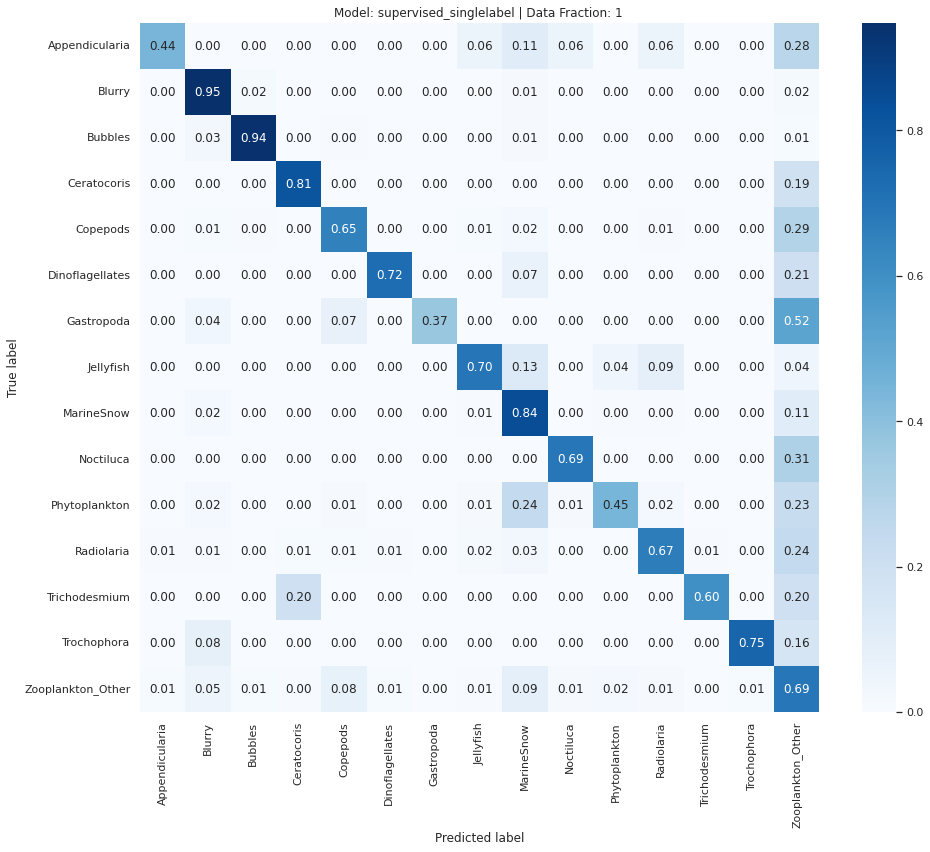

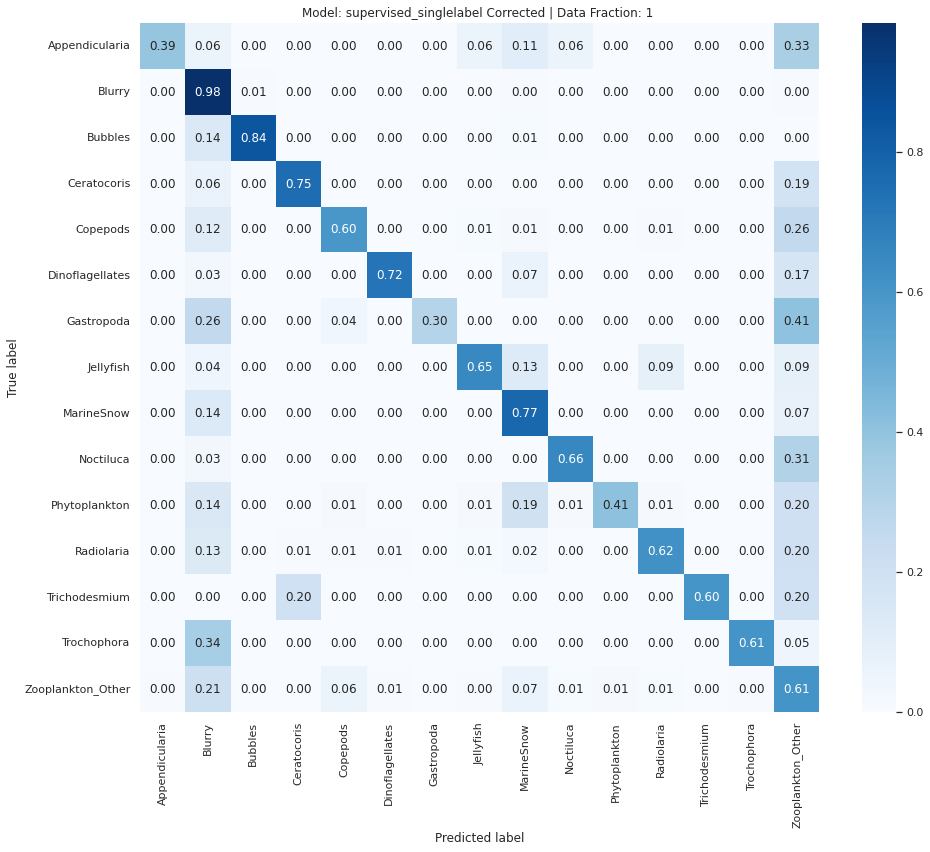

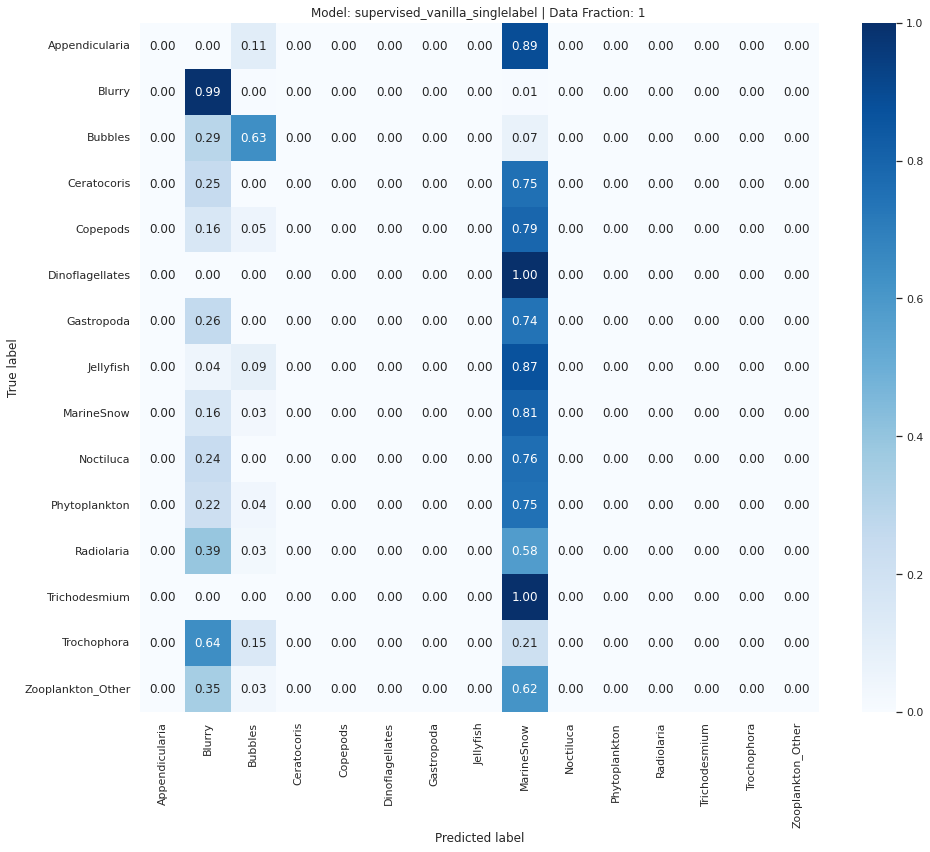

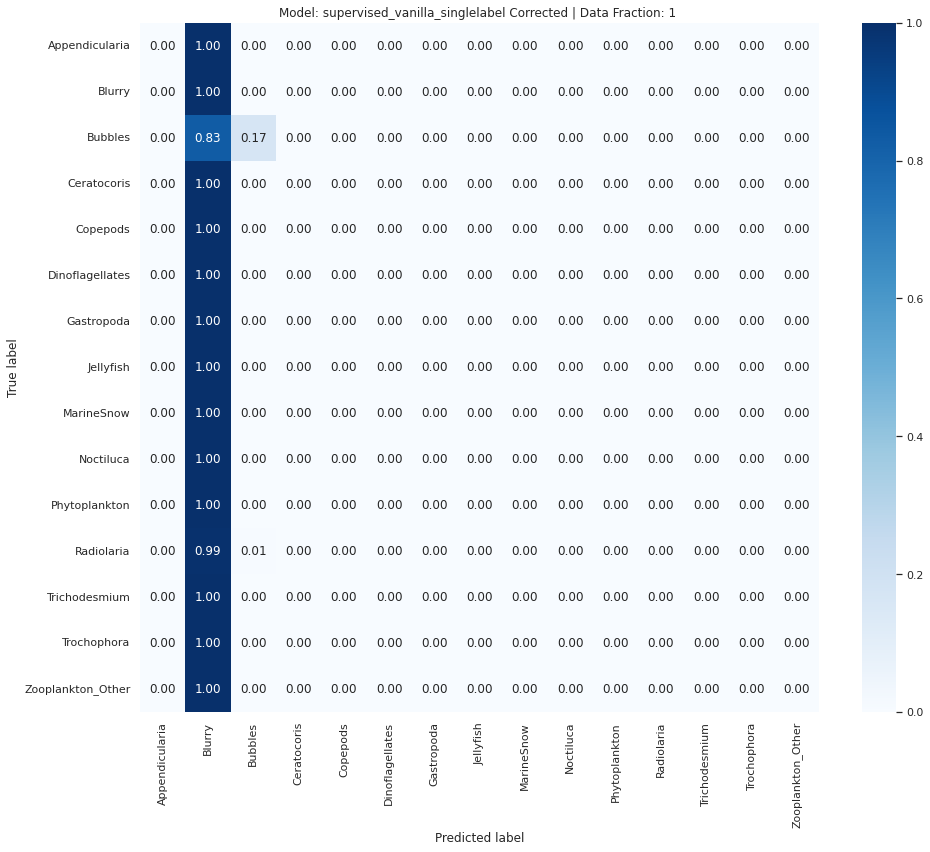

In [38]:
cm_models = ["supervised_singlelabel", "supervised_vanilla_singlelabel",]
cm_fractions = [1]
cm_kinds = ["CM Uncorrected Normalized", "CM Corrected Normalized"]

for cm_fraction in cm_fractions:
    for cm_model in cm_models:
        for cm_kind in cm_kinds:
            single_label_df_001 = single_label_df[single_label_df["Data Fraction"] == cm_fraction]
            cf_matrix = single_label_df_001.loc[cm_model][cm_kind].item().numpy()
            fig, ax = plt.subplots(figsize=(14, 12))
            df_cm = pd.DataFrame(cf_matrix, index = [i for i in datamodule.unique_labels],
                                 columns = [i for i in datamodule.unique_labels])
            sns.heatmap(df_cm, annot=True, fmt=".2f", ax=ax, cmap="Blues")
            ax.set_xlabel("Predicted label")
            ax.set_ylabel("True label")
            if "Uncorrected" in cm_kind:
                ax.set_title(f"Model: {cm_model} | Data Fraction: {cm_fraction} ")
            else:
                ax.set_title(f"Model: {cm_model} Corrected | Data Fraction: {cm_fraction} ")
            plt.tight_layout()
            plt.savefig(f"ConfusionMatrix_{cm_model}_{cm_kind}_{str(cm_fraction).replace('.', '_')}.png", dpi=300)

In [14]:
figsize=(6,3)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


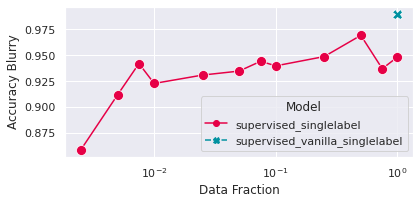

In [15]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy Blurry", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


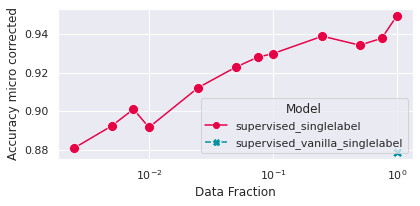

In [16]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy micro corrected", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )
# ax.plot(single_label_df["Data Fraction"], [0.89 for _ in single_label_df["Data Fraction"]], color="grey", ls="-.")
# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
# ax.set_ylim(0.8, 1.1)
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


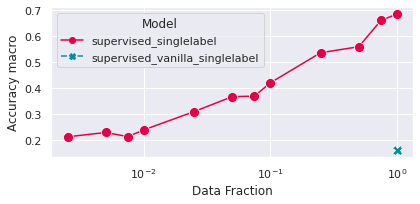

In [17]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy macro", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel_Macro_uncorrected.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


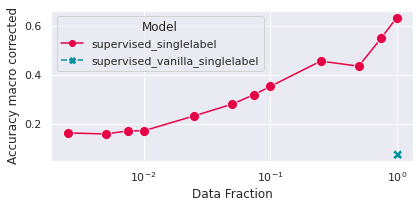

In [18]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy macro corrected", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )
# ax.plot(single_label_df["Data Fraction"], [1/15 for _ in single_label_df["Data Fraction"]], color="grey", ls="--")
# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel_Macro_corrected.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


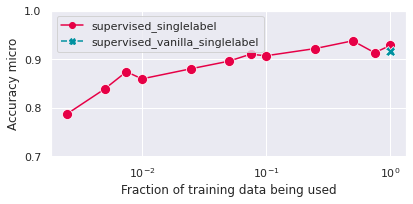

In [19]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy micro", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xlabel("Fraction of training data being used")
ax.set_ylim(0.7, 1)
ax.set_xscale("log")
ax.legend()
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel_micro_pure.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


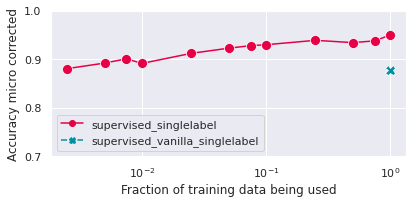

In [20]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Accuracy micro corrected", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item,0.3,f'{item * 100:.0f}%',color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_xlabel("Fraction of training data being used")
ax.set_ylim(0.7, 1)
ax.legend()
plt.tight_layout()
plt.savefig("Accuracies_Testing_Singlelabel_micro_corrected.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


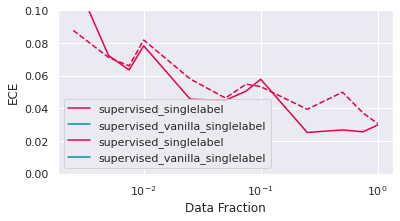

In [21]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="ECE", hue="Model", linestyle="solid", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

sns.lineplot(x="Data Fraction", y="ECE Prior Corrected", hue="Model", linestyle="dashed",
        data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# sns.lineplot(x="Data Fraction", y="ECE Temp Corrected", hue="Model", linestyle=":",
#         data=single_label_df, ax=ax,
#              palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item, 0.2, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_ylim(0, 0.1)
ax.legend(loc="best")
plt.savefig("ECE_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


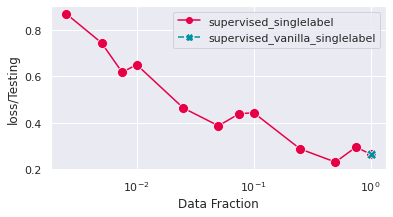

In [22]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="loss/Testing", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item, 0.6, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.legend(loc="best")
plt.savefig("NLL_Testing_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


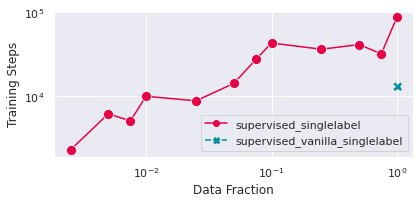

In [23]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Training Steps", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

# for item in data_splits_per_experiment:
#     ax.text(item, 0.6, f'{item * 100:.0f}%', color="grey", horizontalalignment="center", rotation=-45)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc="best")
plt.tight_layout()
plt.savefig("Training_Steps_Singlelabel.png", dpi=300)

/gpfs/home/machnitz/miniconda3/envs/plankton/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


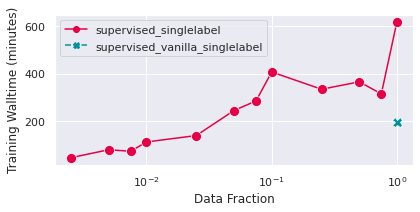

In [24]:
fig, ax = plt.subplots(figsize=figsize)
sns.lineplot(x="Data Fraction", y="Wall time", hue="Model", style="Model", data=single_label_df, ax=ax,
             palette=hereon_color_array, markers=True, markersize=10, )

ax.set_ylabel("Training Walltime (minutes)")

ax.set_xscale("log")
# ax.set_yscale("log")
ax.legend(loc="best")
plt.tight_layout()
plt.savefig("Traing_Walltimes_Singlelabel.png", dpi=300)

In [39]:
predicted_dist_dict = dict()
for key in datamodule.unique_labels:
    predicted_dist_dict[key] = dict()

for model, index_2 in single_label_df.index:
    pd_series = single_label_df.loc[model, index_2]
    predicted_dist_corrected = pd_series["Predicted Distribution corrected"]
    predicted_dist = pd_series["Predicted Distribution"]
    data_fraction = pd_series["Data Fraction"]
    summed_probabilities = pd_series["Summed probabilities"]
    summed_probabilities_corrected = pd_series["Summed probabilities corrected"]
    if data_fraction != 1:
        continue

    for key, value, corrected_value, real_value, summed_prob, summed_prob_corrected in zip(predicted_dist_dict.keys(), predicted_dist, predicted_dist_corrected, real_distribution, summed_probabilities, summed_probabilities_corrected):
        if not model in predicted_dist_dict[key].keys():
            predicted_dist_dict[key][model] = dict()
        predicted_dist_dict[key][model][data_fraction] = dict()
        predicted_dist_dict[key][model][data_fraction]["Predicted count"] = value
        predicted_dist_dict[key][model][data_fraction]["Predicted count corrected"] = corrected_value
        predicted_dist_dict[key][model][data_fraction]["Real count"] = real_value
        predicted_dist_dict[key][model][data_fraction]["Summed probability"] = summed_prob
        predicted_dist_dict[key][model][data_fraction]["Summed probability corrected"] = summed_prob_corrected

dfs = dict()
for key, value in predicted_dist_dict.items():
    try:
        reform = {(outerKey, innerKey): values for outerKey, innerDict in value.items() for innerKey, values in
                  innerDict.items()}
        distribution_df = pd.DataFrame.from_dict(reform).T
        distribution_df.index.names = ("Model", "Data Fraction")
        dfs[key] = distribution_df.reset_index().sort_values(by=["Model"])
    except ValueError:
        continue

In [40]:
distribution_df

,,Predicted count,Predicted count corrected,Real count,Summed probability,Summed probability corrected
Model,Data Fraction,,,,,
supervised_singlelabel,1.0,1928,1281,1296,tensor(2135.9180),tensor(1648.9100)
supervised_vanilla_singlelabel,1.0,0,0,1296,tensor(937.8069),tensor(469.4240)


In [27]:
dfs["Appendicularia"]

,Model,Data Fraction,Predicted count,Predicted count corrected,Real count
0,supervised_singlelabel,1.0,23,15,18
1,supervised_vanilla_singlelabel,1.0,0,0,18


ValueError: Could not interpret input 'Predicted Count'

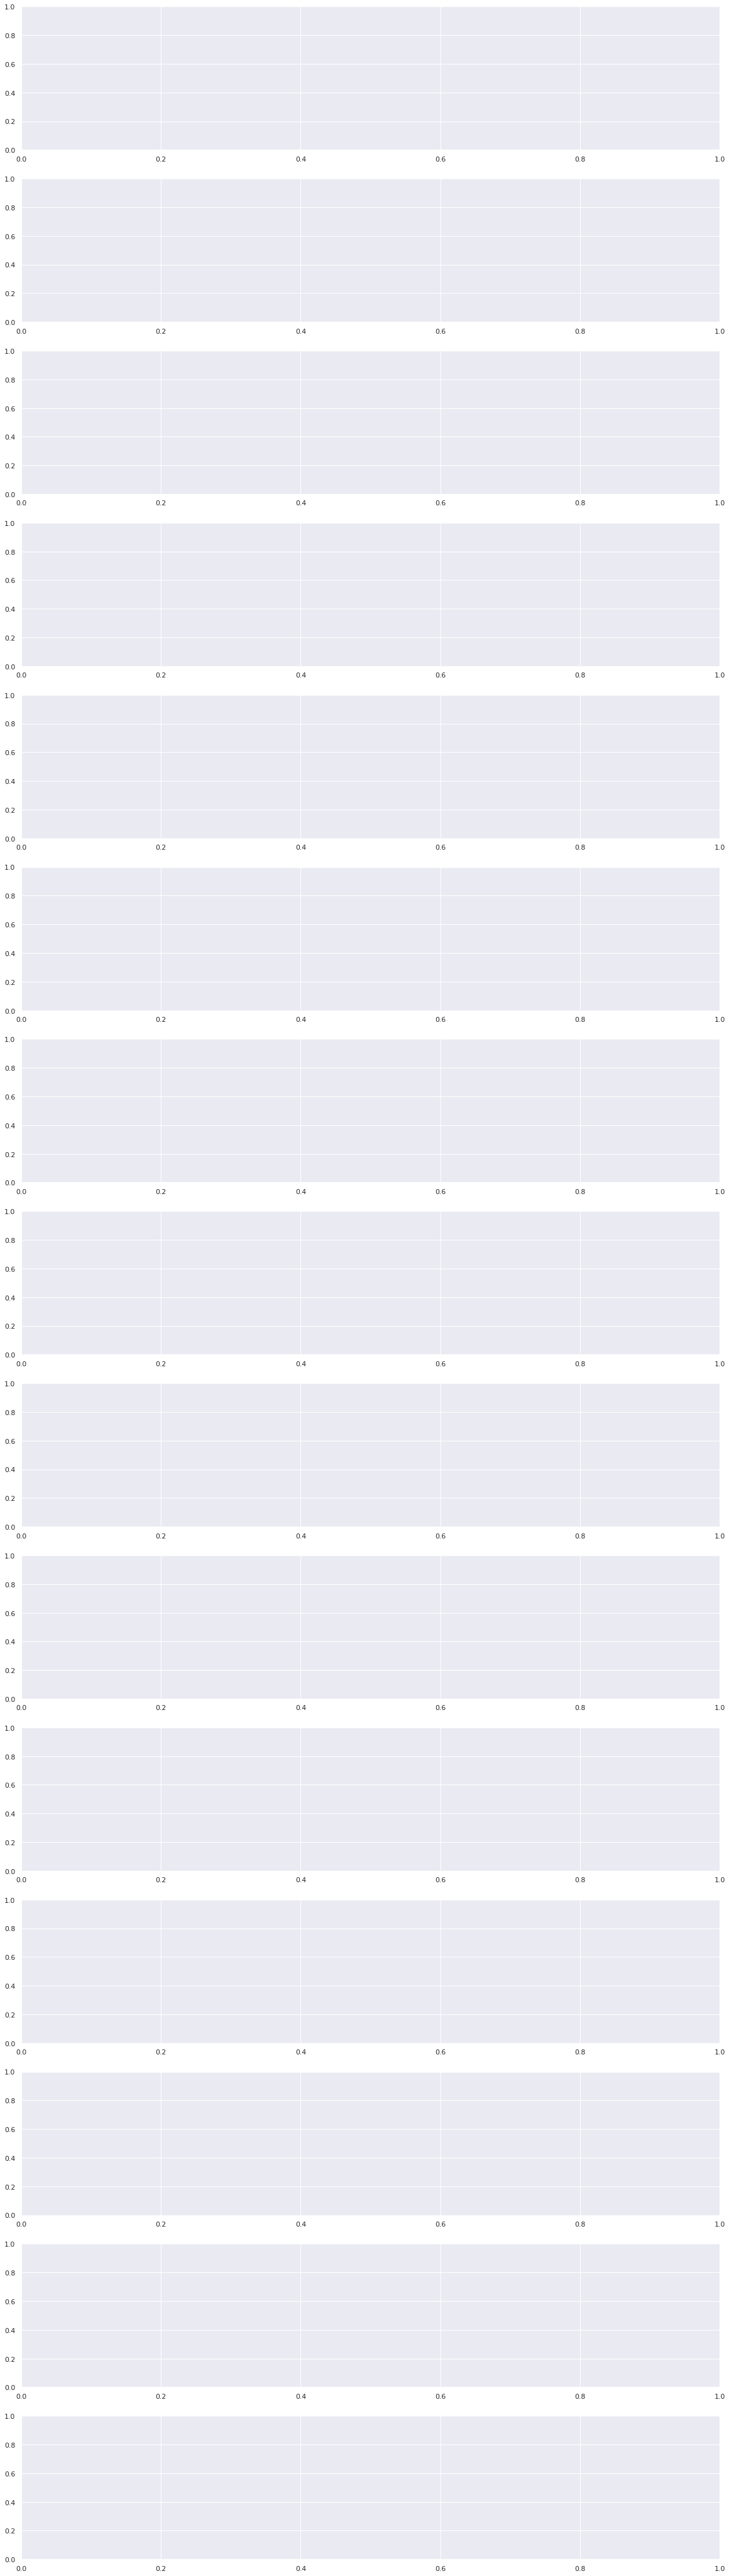

In [28]:
fig, axes = plt.subplots(nrows=len(dfs.keys()), figsize=(20,5 *len(dfs.keys())))

for ax, species in zip(axes.flatten(), dfs.keys()):
    sns.barplot(x="Data Fraction", y="Predicted Count", hue="Model", data=dfs[species], ax=ax)
    
    max_height =  min(dfs[species]["Predicted Count"].mean() * 2, dfs[species]["Real Count"].max() * 50)
    ax.set_ylim(0, max_height)

    
    ax.plot(np.linspace(-5, 20, 100), [dfs[species]["Real Count"].max() for x in np.linspace(-2, 2, 100)], c="black", ls="--", label="True Count")
    ax.set_xlim(-0.5,12.5)
    # ax.set_xlabel("true samples")
    ax.set_ylabel(f"Predicted Count {species}")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.legend(loc="upper right")
    
    
    for p in ax.patches:
        if p.get_height() > max_height:
            color = p.get_facecolor()
            if sum(color) < 2.6:
                text_color="white"
            else:
                text_color="black"
            ax.annotate(int(p.get_height()),
                        (p.get_x() + p.get_width() / 2., max_height * 0.66),
                        ha='center', va='center',
                        rotation=90,
                        xytext=(0, 9),
                        textcoords='offset points',
                        color=text_color)
plt.show()
plt.savefig("AllPredictedDistributions.png", dpi=300)

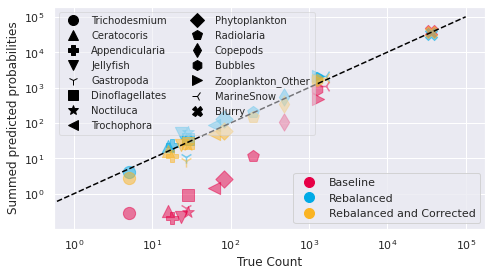

In [46]:
cm_fraction = 1

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(np.arange(0, int(1e5)), c="black", ls="--")

alpha = 0.5
markersize = 150
handles = []
model_handles = []

markers = ["o","^", "P", "v","1",  "s", "*", "<", "D", "p", "d", "h" , ">",  "3", "X",]
# ==================================================
color = hereon_color_array[0]

for idx, species in enumerate(np.array(list(dfs.keys()))[np.argsort(real_distribution)]):
    species_df = dfs[species].loc[dfs[species]["Data Fraction"] == cm_fraction]
    model_df = species_df[species_df["Model"] == "supervised_vanilla_singlelabel"]
    model_df.loc[model_df["Predicted count"] == 0, "Predicted count"] = 0.3
    ax.scatter(x=model_df["Real count"], y=model_df["Summed probability corrected"], color=color, s=markersize, marker=markers[idx], alpha=alpha, clip_on=False)

model_handles.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None',
              markersize=10, label='Baseline'))

# ==================================================
color = hereon_color_array[2]
for idx, species in enumerate(np.array(list(dfs.keys()))[np.argsort(real_distribution)]):
    species_df = dfs[species].loc[dfs[species]["Data Fraction"] == cm_fraction]
    model_df = species_df[species_df["Model"] == "supervised_singlelabel"]

    ax.scatter(x=model_df["Real count"], y=model_df["Summed probability"], color=color, s=markersize, marker=markers[idx], alpha=alpha, clip_on=False)
    model_df.loc[model_df["Predicted count"] == 0, "Predicted count"] = 0.3

model_handles.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                             markersize=10, label='Rebalanced'))


# ==================================================
color = hereon_color_array[3]
for idx, species in enumerate(np.array(list(dfs.keys()))[np.argsort(real_distribution)]):
    species_df = dfs[species].loc[dfs[species]["Data Fraction"] == cm_fraction]
    model_df = species_df[species_df["Model"] == "supervised_singlelabel"]
    model_df.loc[model_df["Predicted count corrected"] == 0, "Predicted count corrected"] = 0.3

    ax.scatter(x=model_df["Real count"], y=model_df["Summed probability corrected"], color=color, s=markersize, marker=markers[idx], alpha=alpha, clip_on=False)

model_handles.append(mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                             markersize=10, label='Rebalanced and Corrected'))


for idx, species in enumerate(np.array(list(dfs.keys()))[np.argsort(real_distribution)]):
    handles.append(mlines.Line2D([], [], color='black', marker=markers[idx], linestyle='None',
                  markersize=10, label=species))

# ==================================================
ax.set_xlabel("True Count")
ax.set_ylabel(f"Summed predicted probabilities")
# ax.set_title(f"Fraction: {cm_fraction}")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_ylim(1, 2e5)
# ax.set_xticks(np.sort(real_distribution))
# ax.set_xticklabels(np.array(list(dfs.keys()))[np.argsort(real_distribution)], rotation=90)

legend1 = plt.legend(handles=handles, loc="upper left", ncol=4, framealpha=0.5, fontsize=10)
ax.legend(handles=model_handles, loc="lower right")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.savefig(f"AllPredictedDistributionsSummedProbs_Bayes.pdf")
plt.show()
plt.close("all")

In [85]:
handles

In [86]:
real_distribution

array([   18, 35801,  1263,    16,   484,    29,    27,    23,  1648,
          29,    83,   191,     5,    61,  1296])

In [87]:
np.argsort(real_distribution)

array([12,  3,  0,  7,  6,  5,  9, 13, 10, 11,  4,  2, 14,  8,  1])

In [29]:
mini_df = single_label_df[single_label_df["Data Fraction"] == 1][["Accuracy micro", "Accuracy micro corrected", "Accuracy macro", "Accuracy macro corrected"]]
mini_df = mini_df.reset_index().drop(columns="Experiment")

acc_dict_micro = {
    "Baseline accuracy": [mini_df.iloc[1]["Accuracy micro"]],
    "Rebalanced accuracy": [mini_df.iloc[0]["Accuracy micro"]],
    "Rebalanced and corrected accuracy": [mini_df.iloc[0]["Accuracy micro corrected"]]
}
acc_micro_df = pd.DataFrame.from_dict(acc_dict_micro).T.reset_index()
acc_dict_macro = {
    "Baseline": [mini_df.iloc[1]["Accuracy macro"]],
    "Rebalanced": [mini_df.iloc[0]["Accuracy macro"]],
    "Rebalanced and\ncorrected": [mini_df.iloc[0]["Accuracy macro corrected"]]
}
acc_macro_df = pd.DataFrame.from_dict(acc_dict_macro).T.reset_index()

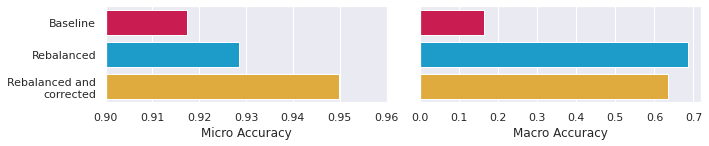

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,2.2))
sns.barplot(x=0, y="index", data=acc_micro_df, palette=hereon_color_array[np.array([0, 2, 3])], ax=ax1)
sns.barplot(x=0, y="index", data=acc_macro_df, palette=hereon_color_array[np.array([0, 2, 3])], ax=ax2)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.set_xlabel("Micro Accuracy")
ax2.set_xlabel("Macro Accuracy")
ax1.set_xlim(0.9, 0.96)
plt.tight_layout()
plt.savefig("BayesianAccsComparison.pdf")
plt.show()


In [83]:
acc_micro_df

,index,0
0,Baseline accuracy,0.917435
1,Rebalanced accuracy,0.928442
2,Rebalanced and corrected accuracy,0.949822


In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(3,2.2))
sns.barplot(x=0, y="index", data=acc_micro_df, palette=hereon_color_array[np.array([0, 2, 3])], ax=ax1)
sns.barplot(x=0, y="index", data=acc_macro_df, palette=hereon_color_array[np.array([0, 2, 3])], ax=ax2)
ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.set_xlabel("Micro Accuracy")
ax2.set_xlabel("Macro Accuracy")
ax1.set_xlim(0.9, 0.96)
plt.tight_layout()
plt.savefig("BayesianAccsComparison.pdf")
plt.show()